In [1]:
import comod
from comod import sir

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

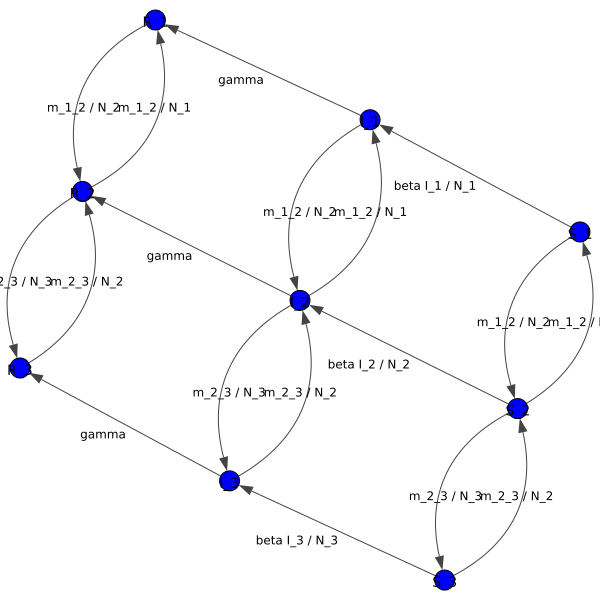

In [3]:
# Build a community model
com_model = comod.CommunityModel(
    comod.sir,  # Base model
    3,  # Number of communities or matrix describing their connections
    "linear",  # Topology model when the previos parameter is an integer
    equal_parameters=True,  # Assume equal parameters in each community
    symmetric_matrix=True,  # Assume transition matrix is symmetric
)
com_model.plot_igraph()  # Check the resulting compartmental model

In [4]:
# Check the differential equations
from IPython.display import display, Math

display(Math(com_model.to_latex()))

<IPython.core.display.Math object>

In [5]:
# Convenience dict for plotting
topology_letter = {"full": "K", "linear": "P", "cycle": "C", "star": "S", "star2": "S"}

In [6]:
t = np.linspace(0, 250, 250)
population = 1
m = 0.0001
initial_fraction = 0.001
beta = 0.3
gamma = 0.1

topology = "linear"
n = 5

com_model = comod.CommunityModel(
    comod.sir, n, topology, equal_parameters=True, symmetric_matrix=True
)

results = com_model.solve(
    population
    * np.asarray(
        [1 - initial_fraction, initial_fraction, 0] + [1, 0, 0] * (n - 1)
    ),  # Initial state
    [beta, gamma] + [m] * (len(com_model.parameters) - 2),  # Coefficient values
    t,  # Time mesh
)

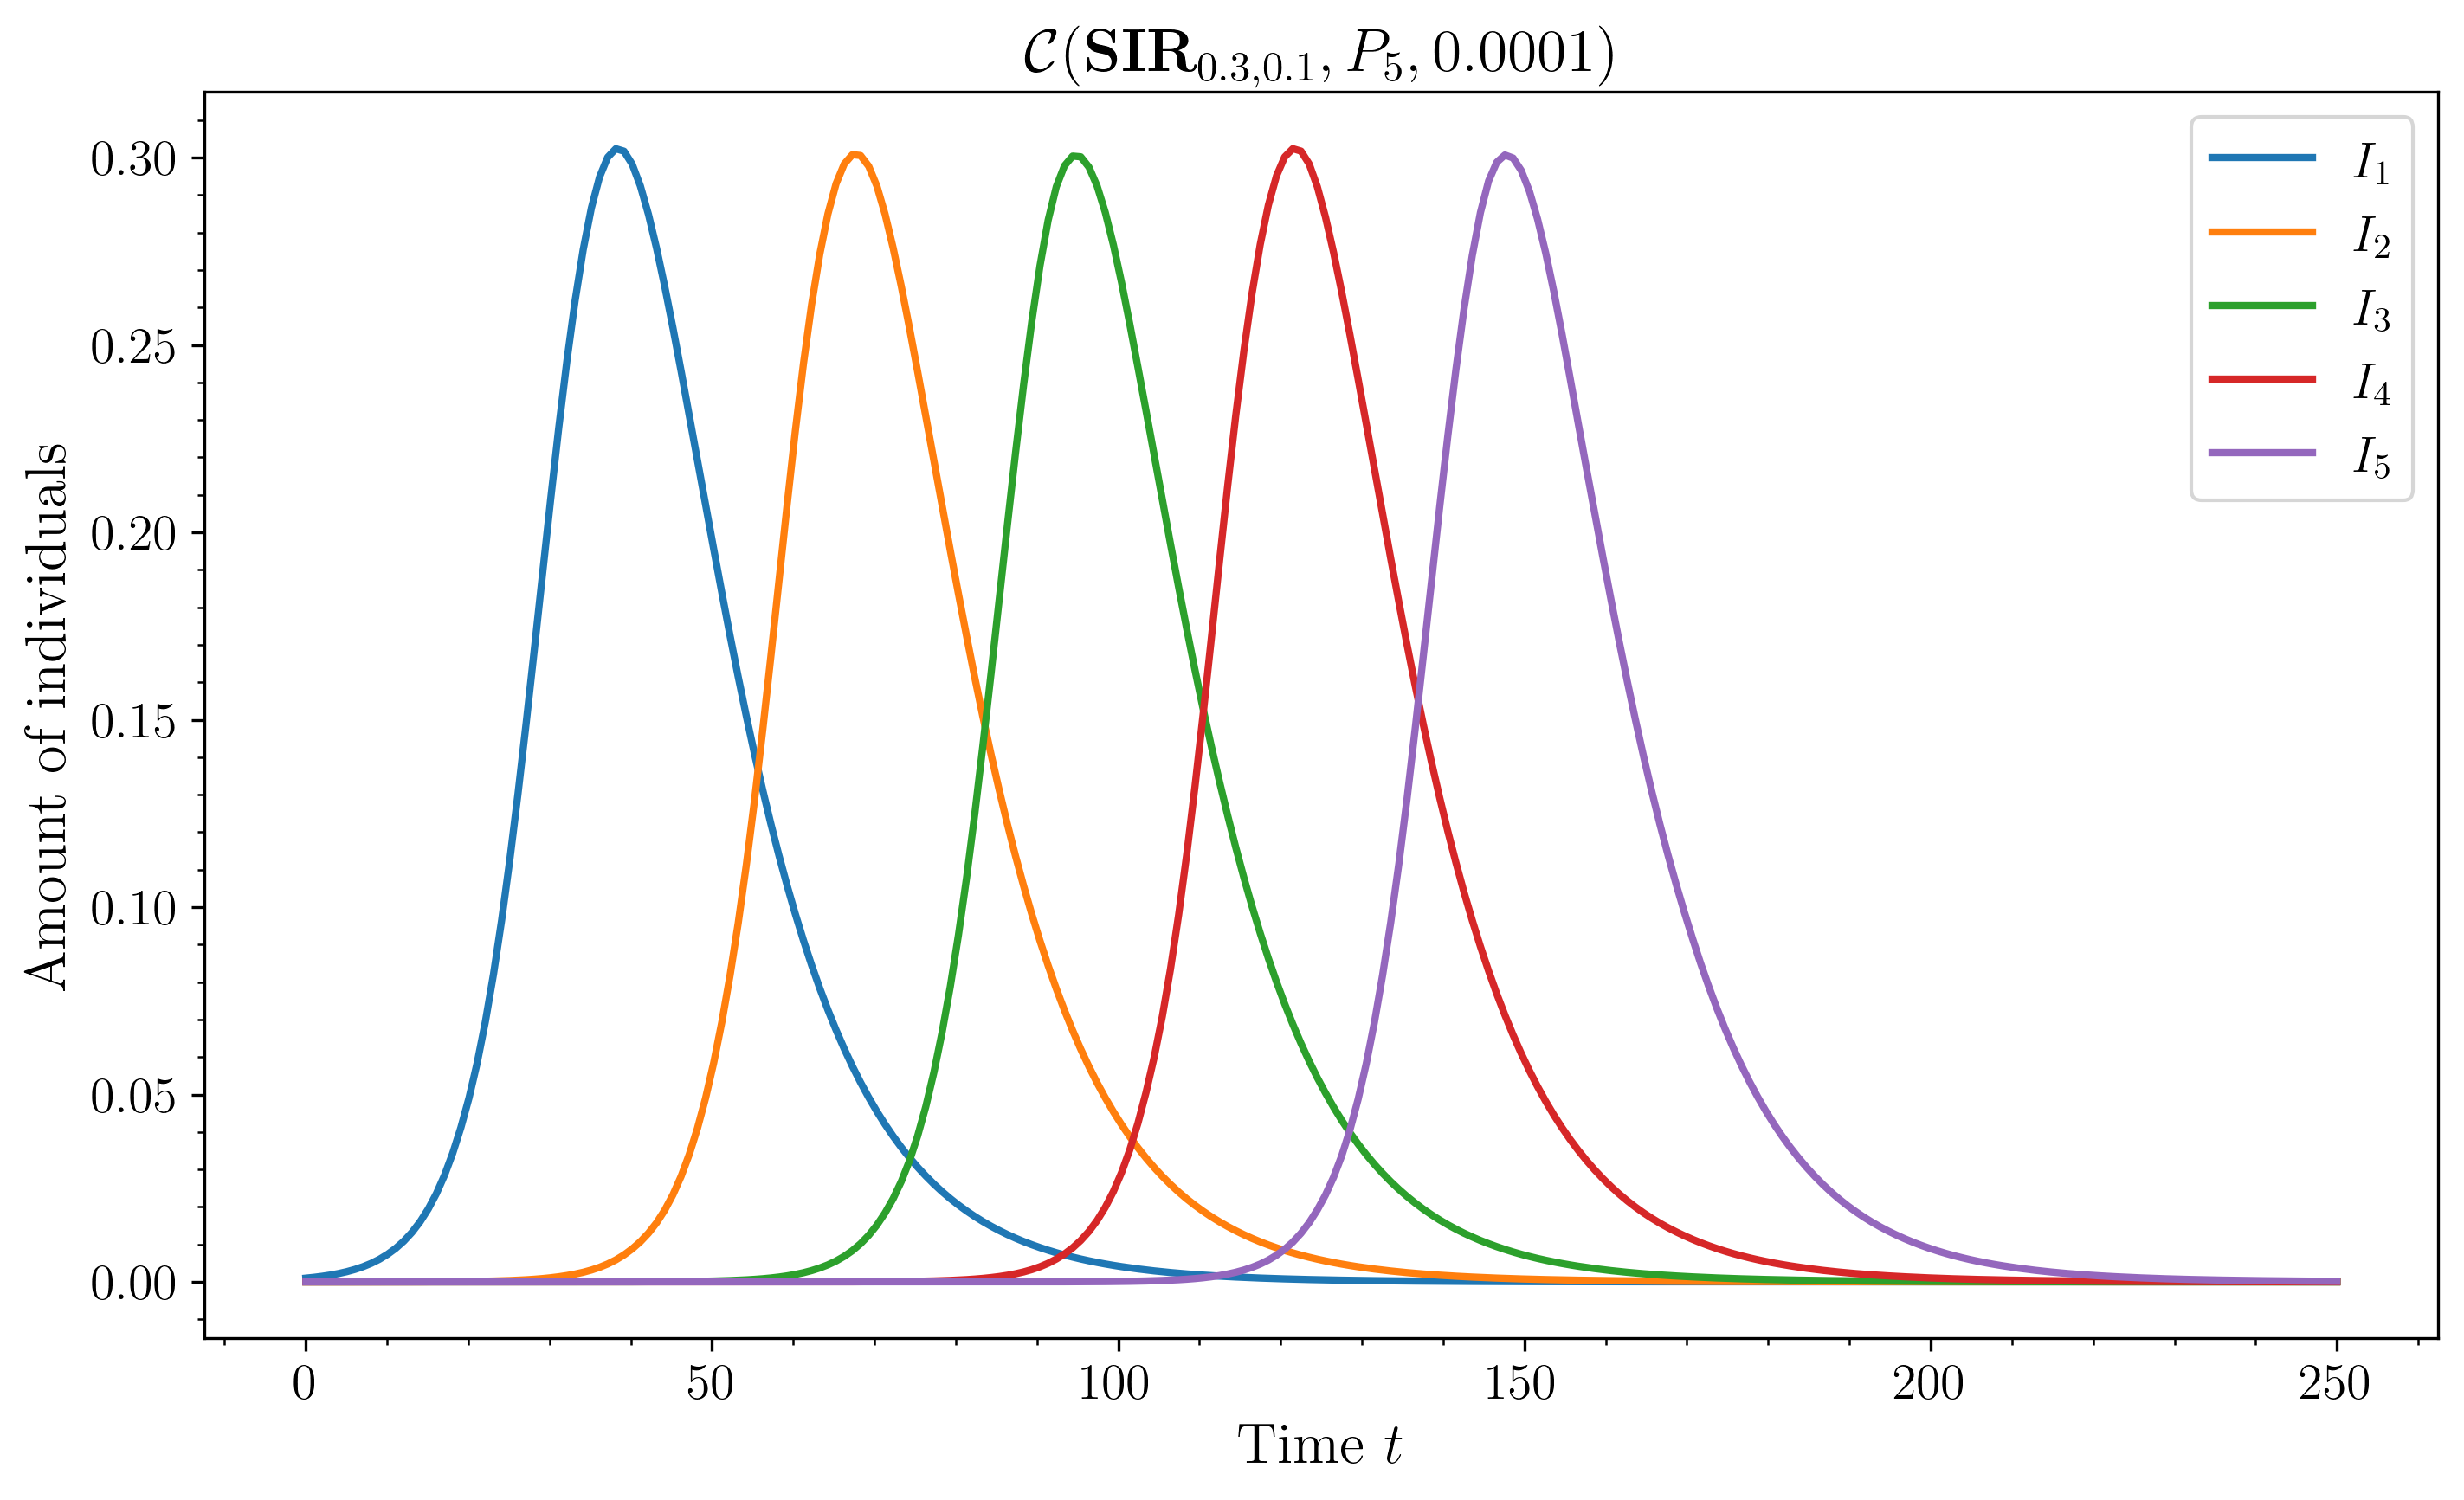

In [7]:
with plt.style.context(["paper"]):
    for i in range(n):
        plt.plot(t, results[1 + 3 * i], label=f"$I_{i+1}$")

    plt.legend()
    plt.xlabel("Time $t$")
    plt.ylabel("Amount of individuals")
    plt.title(
        fr"$\mathcal{{C}}(\mathrm{{\textbf{{SIR}}}}_{{{beta}, {gamma}}}, {topology_letter[topology]}_{n}, {m})$"
    )
    plt.tight_layout()
    plt.savefig(f"out/SIR-{topology}-components.pdf")
    plt.show()

In [8]:
S = np.sum(results[::3], axis=0)
I = np.sum(results[1::3], axis=0)
R = np.sum(results[2::3], axis=0)

In [9]:
# Functions to calculate effective SIR parameters

In [10]:
def effective_R0(SIR):
    SIR = np.asarray(SIR)
    # Central difference (wrt 1:-1)
    S_dot = SIR[0, 2:] - SIR[0, :-2]
    R_dot = SIR[2, 2:] - SIR[2, :-2]
    return -(S_dot * np.sum(SIR[:, 1:-1], axis=0)) / (SIR[0, 1:-1] * R_dot)

In [11]:
def effective_beta(SIR):
    SIR = np.asarray(SIR)
    # Central difference (wrt 1:-1)
    S_dot = (SIR[0, 2:] - SIR[0, :-2]) / 2
    return -(S_dot * np.sum(SIR[:, 1:-1], axis=0)) / (SIR[0, 1:-1] * SIR[1, 1:-1])

In [12]:
def effective_logder_S(SIR):
    SIR = np.asarray(SIR)
    # Central difference (wrt 1:-1)
    S_dot = (SIR[0, 2:] - SIR[0, :-2]) / 2
    return -(S_dot)  # /(SIR[0,1:-1])

In [13]:
def effective_gamma(SIR):
    SIR = np.asarray(SIR)
    # Central difference (wrt 1:-1)
    R_dot = (SIR[2, 2:] - SIR[2, :-2]) / 2
    return R_dot / SIR[1, 1:-1]

In [14]:
fit_pars = sir.best_fit(
    np.asarray([S, I, R]),
    t,
    [beta, gamma],
    target="y",
).x

In [15]:
sliding_fit_pars = sir.best_sliding_fit(
    np.asarray([S, I, R]), t, [beta, gamma], target="y", window_size=10, step_size=10
)

In [16]:
from scipy.interpolate import interp1d

f_list = [
    interp1d(sliding_fit_pars.index, sliding_fit_pars[c], fill_value="extrapolate")
    for c in sliding_fit_pars.columns
]

In [17]:
S_sliding_fit, I_sliding_fit, R_sliding_fit = sir.solve_time(
    (S[0], I[0], R[0]),  # Initial state
    f_list,  # Coefficient values
    t,  # Time mesh
    method="RK45",  # see scipy.integrate.solve_ivp
)

In [18]:
S_fit, I_fit, R_fit = sir.solve(
    (S[0], I[0], R[0]),  # Initial state
    fit_pars,  # Coefficient values
    t,  # Time mesh
    method="RK45",  # see scipy.integrate.solve_ivp
)

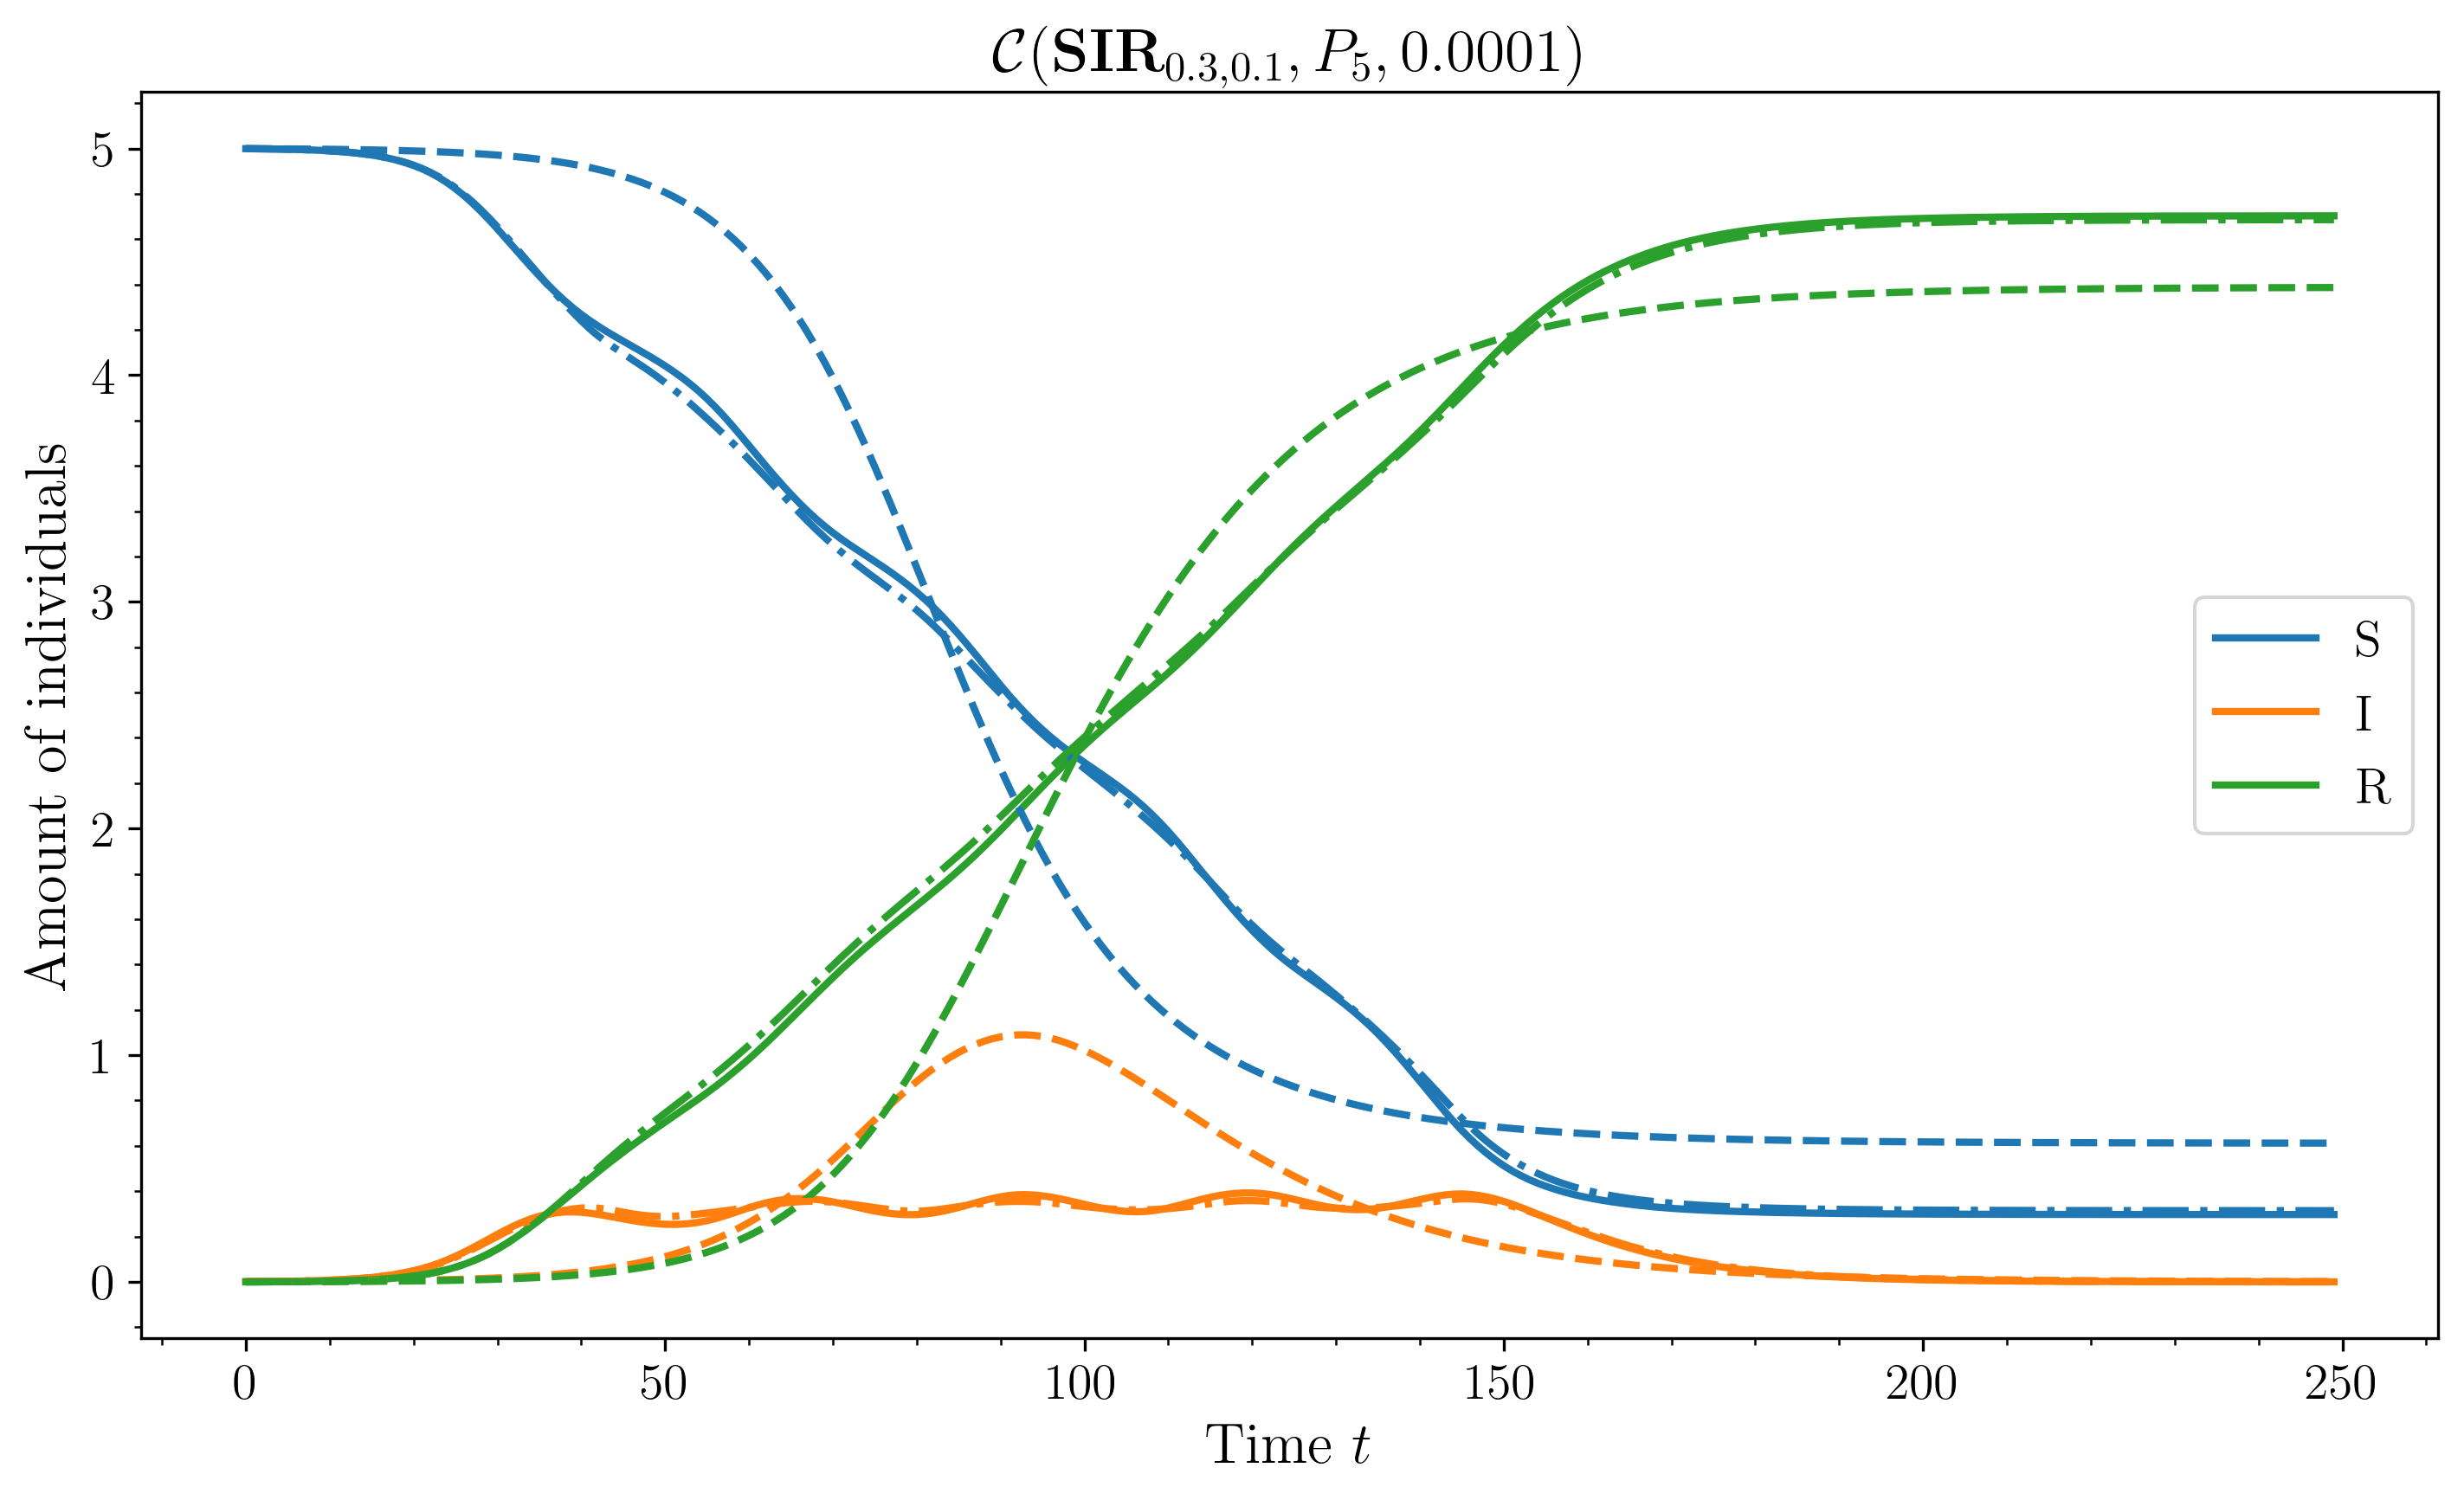

In [19]:
with plt.style.context(["paper"]):
    plt.plot(S)
    plt.plot(I)
    plt.plot(R)
    plt.plot(S_fit, "C0--")
    plt.plot(I_fit, "C1--")
    plt.plot(R_fit, "C2--")
    plt.plot(S_sliding_fit, "C0-.")
    plt.plot(I_sliding_fit, "C1-.")
    plt.plot(R_sliding_fit, "C2-.")

    # errors=(np.sum((S-S_fit)**2), np.sum((I-I_fit)**2), np.sum((R-R_fit)**2))
    # plt.legend([f"{l} ($d_2\\approx{e:.2f}$)" for l,e in zip("SIR", errors)])
    plt.legend(list("SIR"))
    plt.xlabel("Time $t$")
    plt.ylabel("Amount of individuals")
    plt.title(
        fr"$\mathcal{{C}}(\mathrm{{\textbf{{SIR}}}}_{{{beta}, {gamma}}}, {topology_letter[topology]}_{n}, {m})$"
    )

    plt.tight_layout()
    plt.savefig(f"out/SIR-{topology}-global-fit.pdf")
    plt.show()

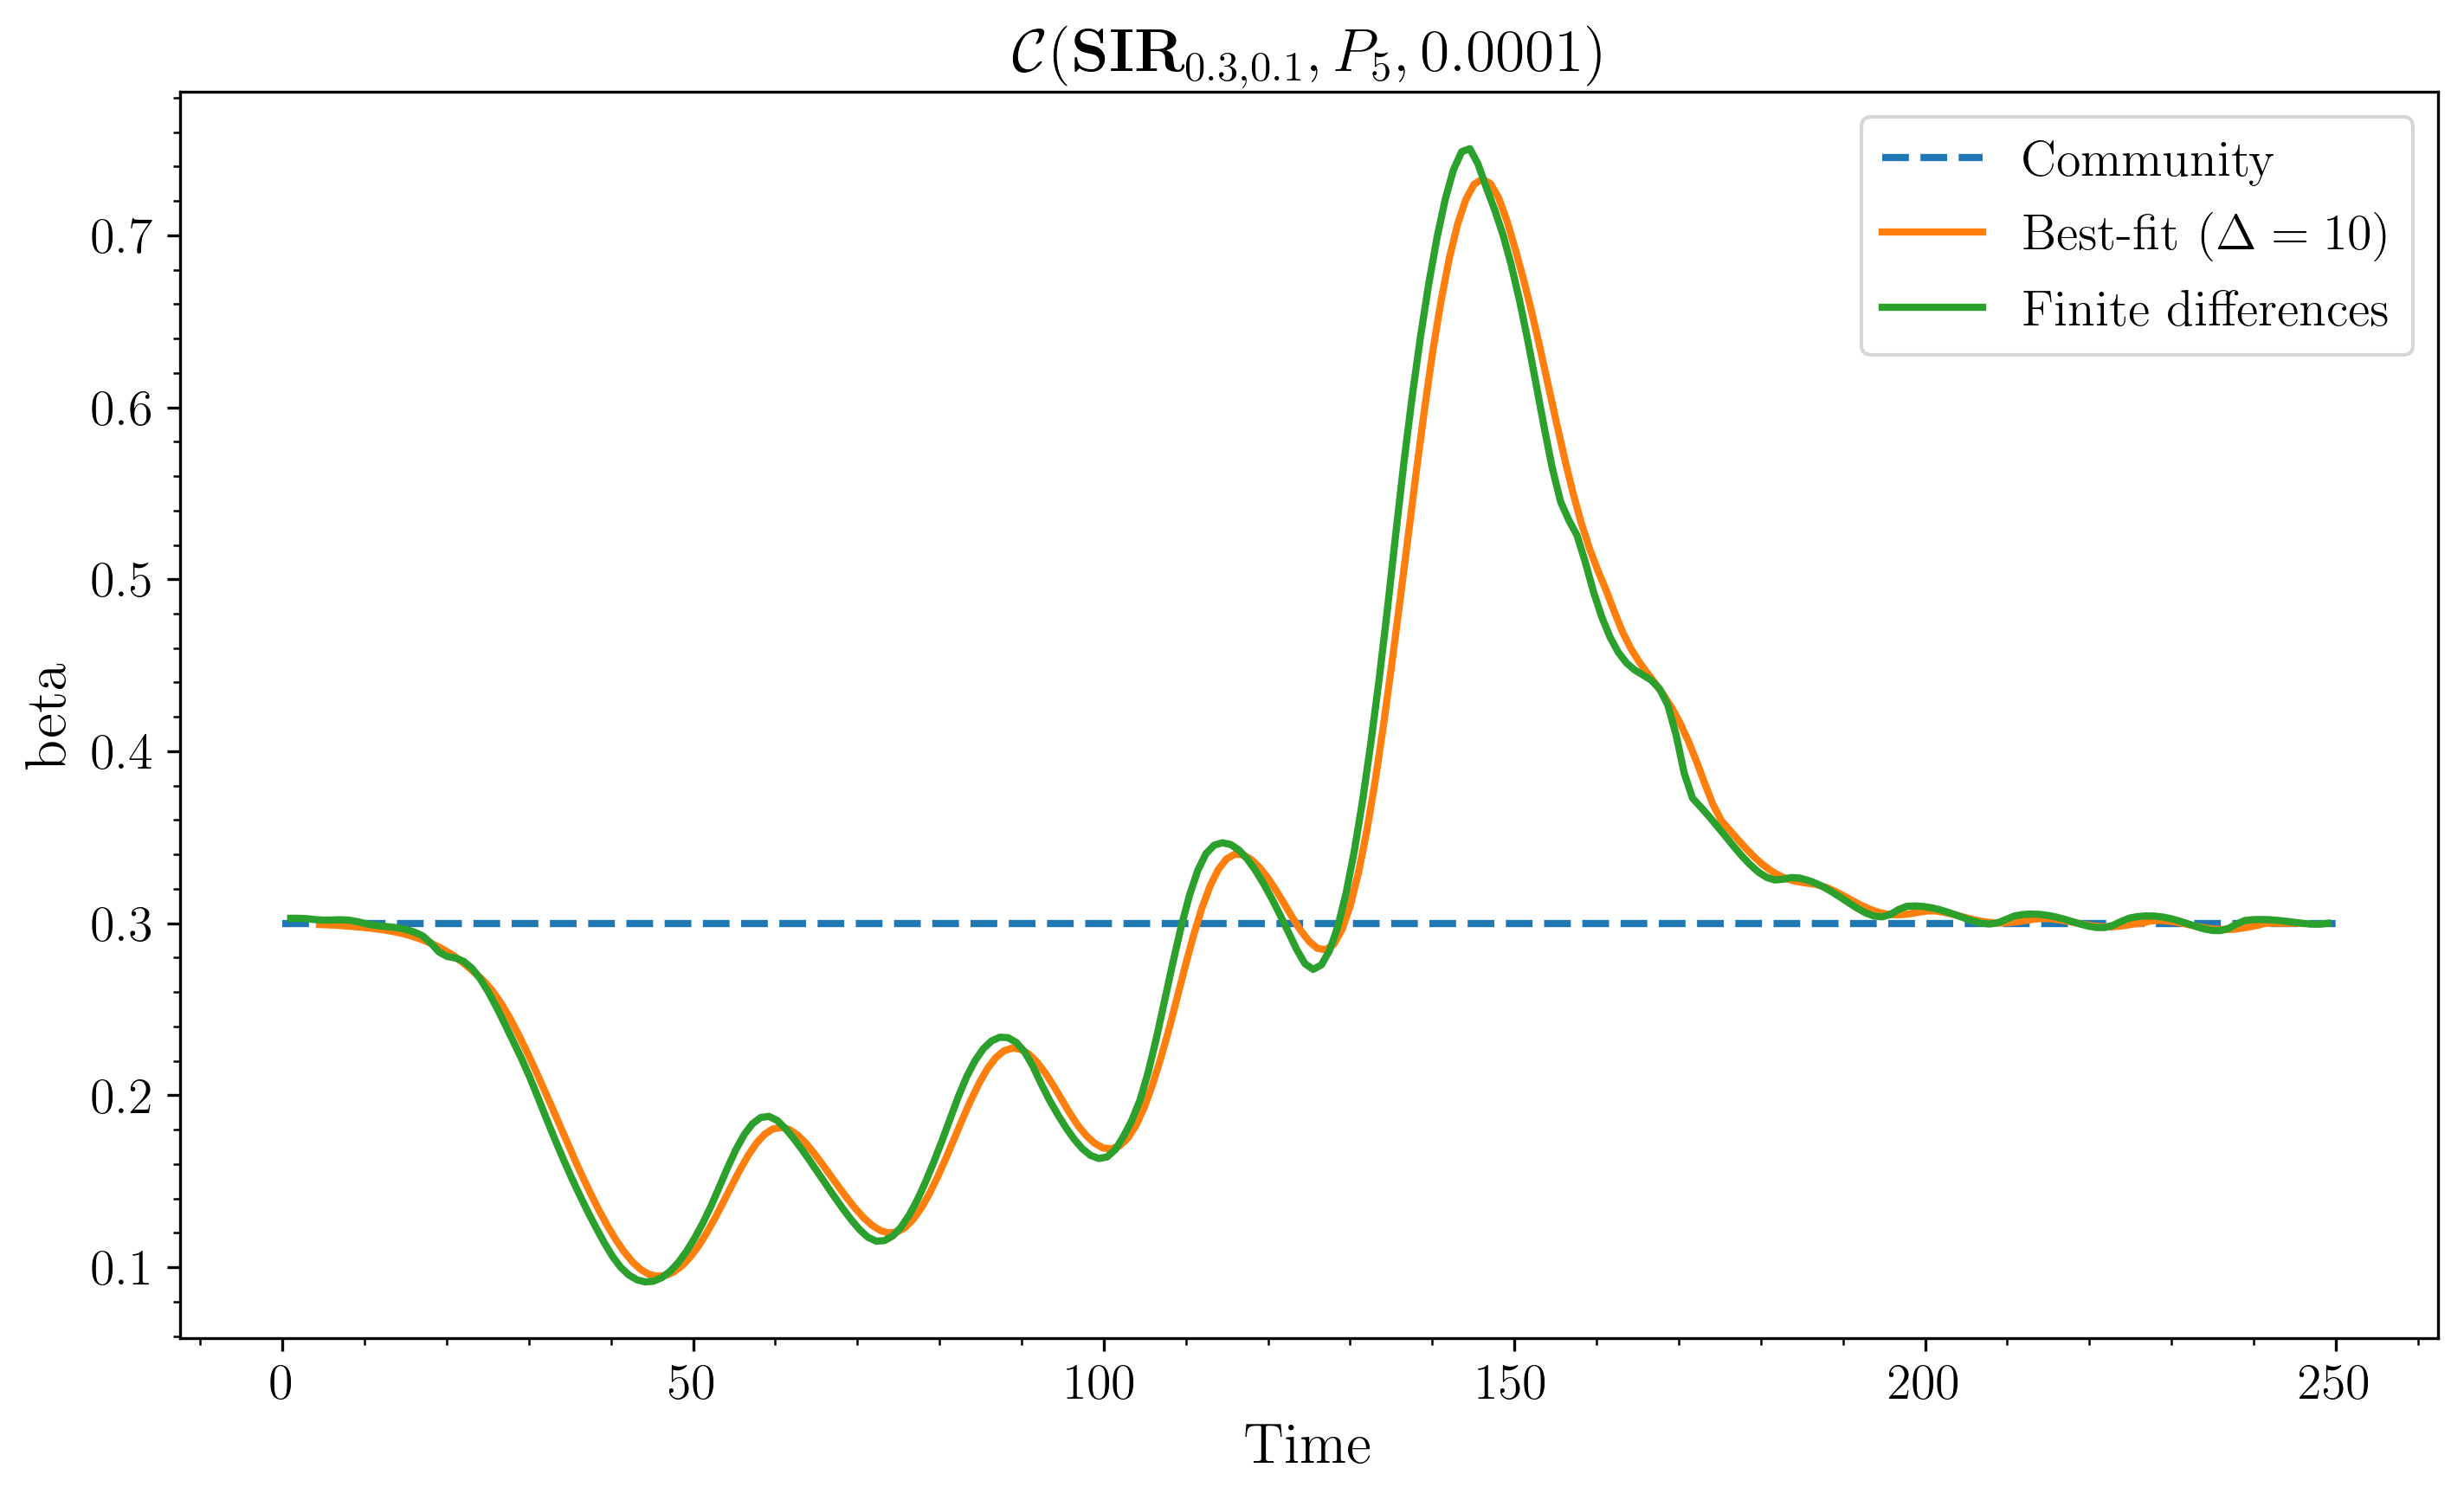

In [20]:
window_size = 10
with plt.style.context(["paper"]):
    sliding_fit = sir.best_sliding_fit(
        (S, I, R), t, (beta, gamma), window_size, 1, target="y"
    )
    plt.plot(t[[0, -1]], [0.3] * 2, "--", label="Community")
    plt.plot(
        sliding_fit.apply(lambda row: row["beta"], axis=1),
        label=f"Best-fit ($\\Delta={window_size}$)",
    )
    plt.plot(t[1:-1], effective_beta((S, I, R)), label="Finite differences")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("beta")
    plt.title(
        fr"$\mathcal{{C}}(\mathrm{{\textbf{{SIR}}}}_{{{beta}, {gamma}}}, {topology_letter[topology]}_{n}, {m})$"
    )
    plt.tight_layout()
    # plt.savefig(f"out/SIR-{topology}-sliding-fit.pdf")
    plt.show()

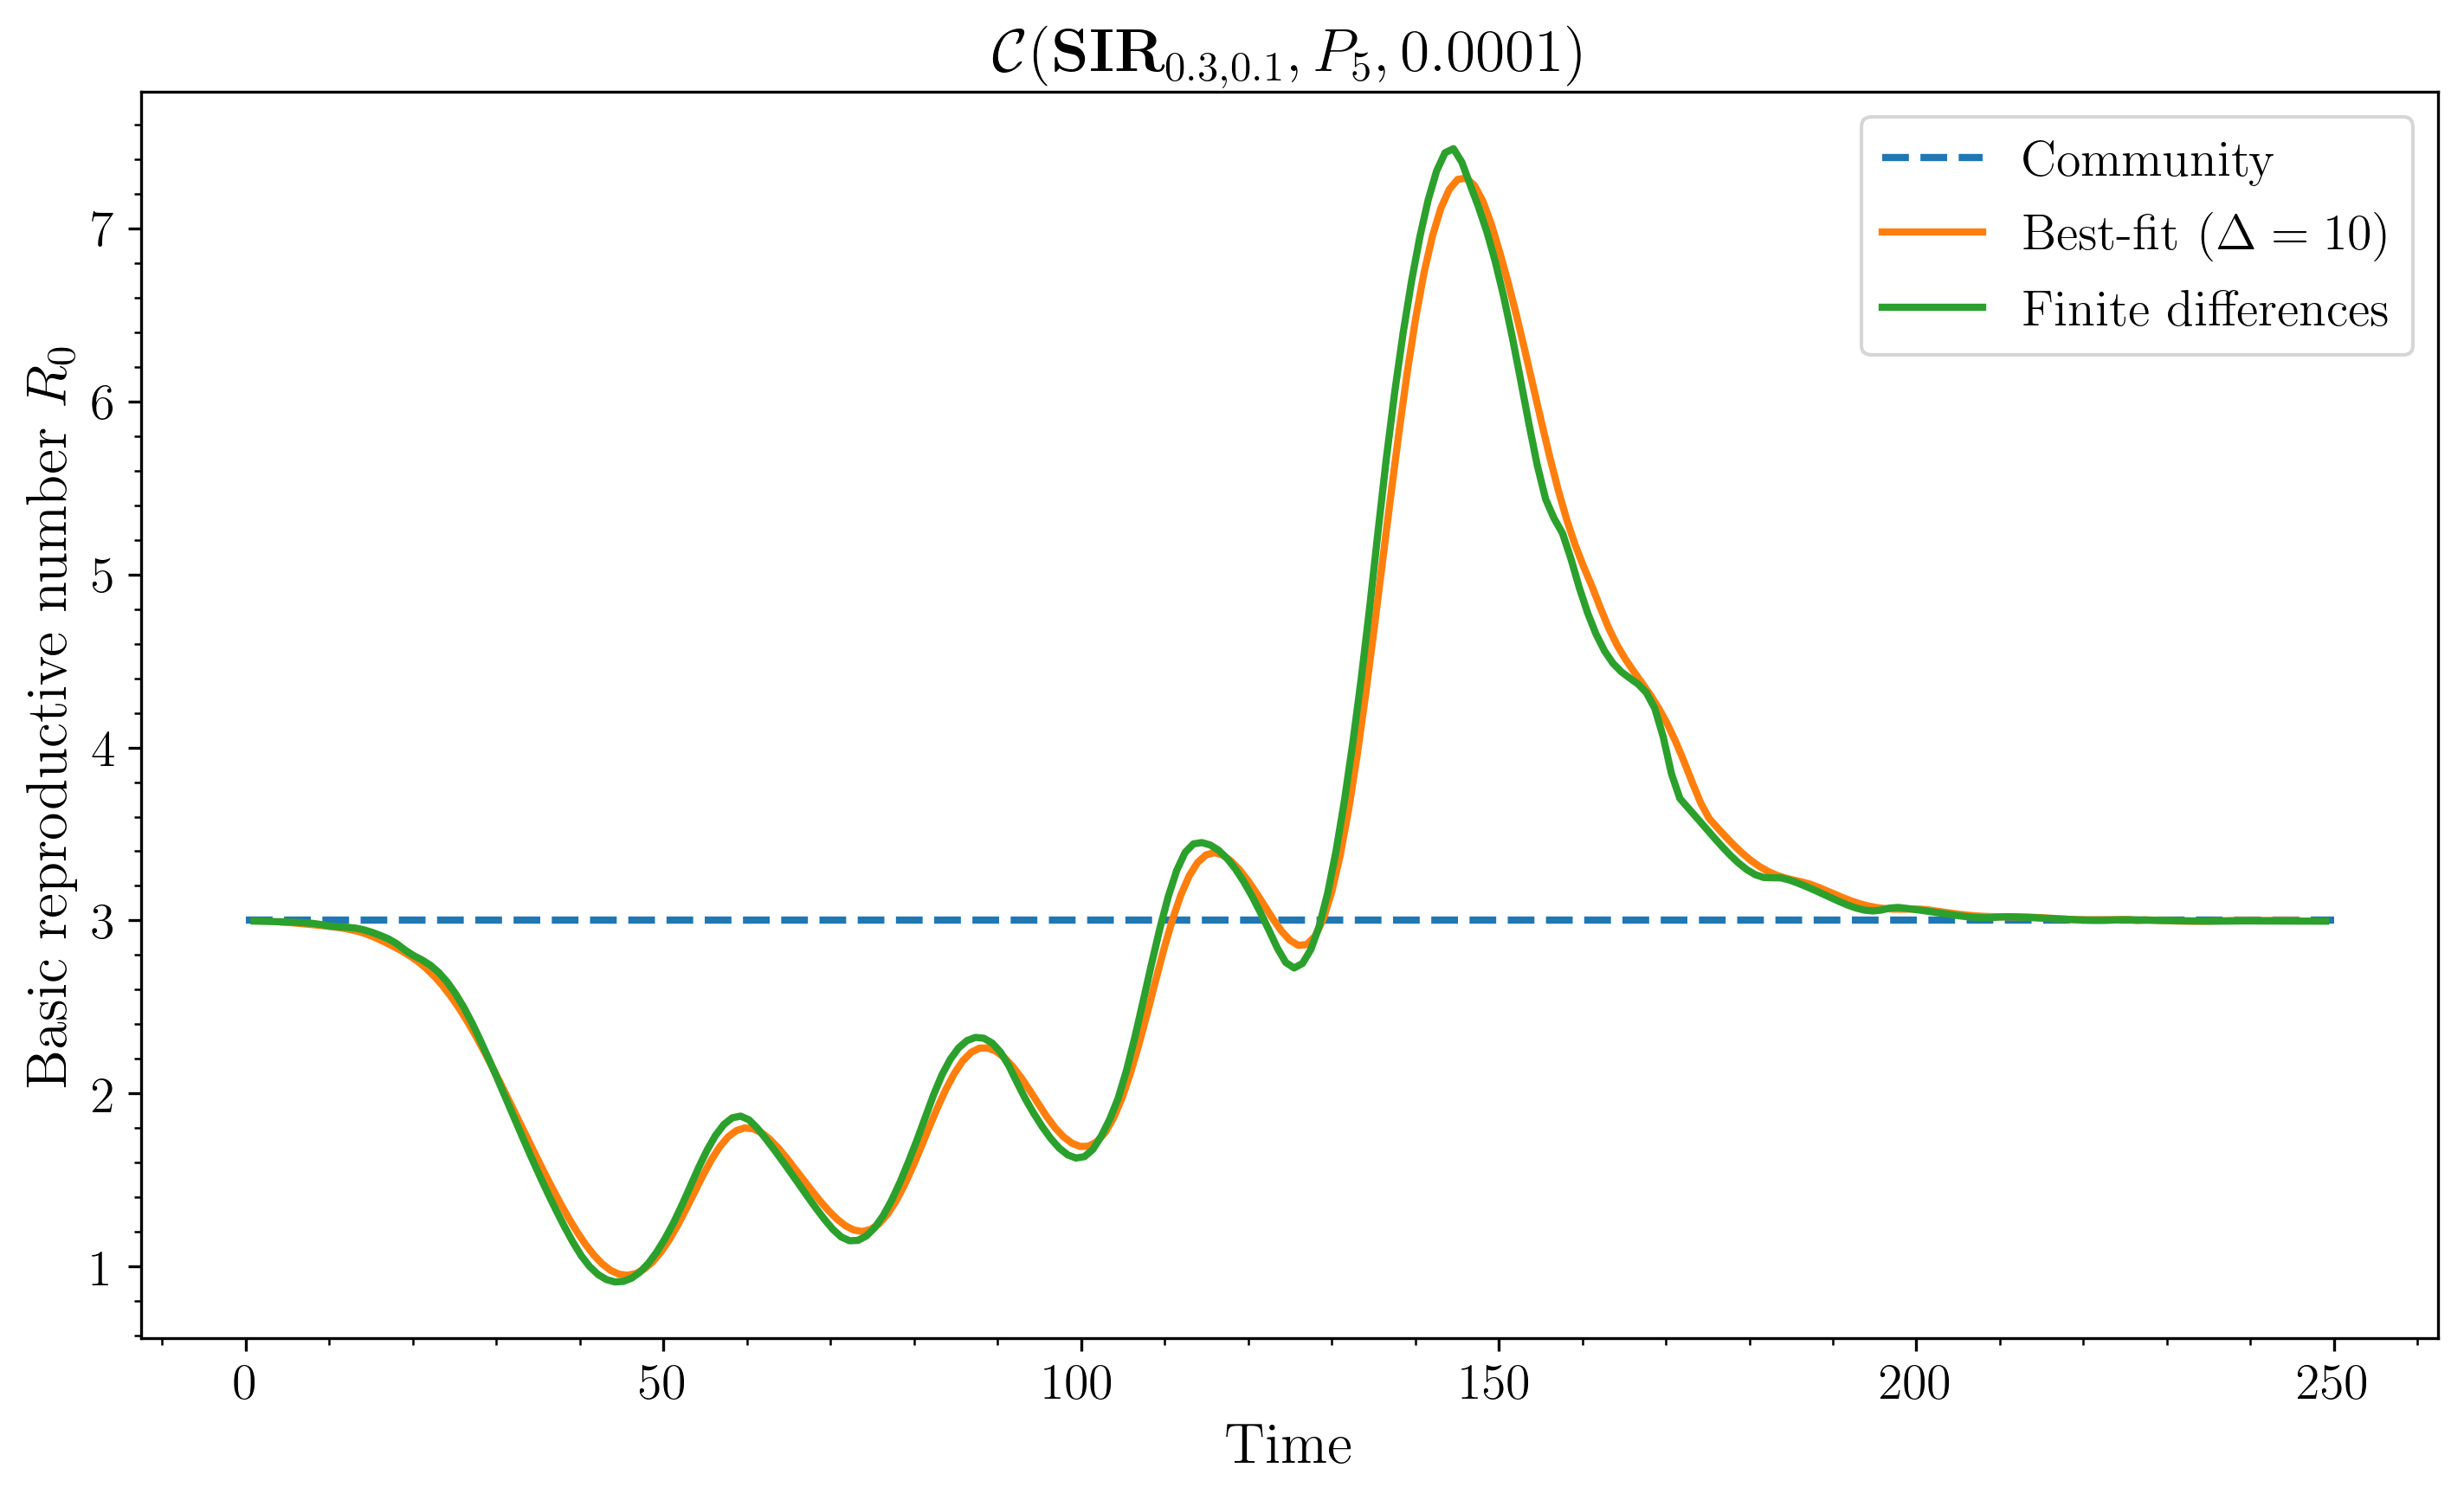

In [21]:
window_size = 10
with plt.style.context(["paper"]):
    sliding_fit = sir.best_sliding_fit(
        (S, I, R), t, (beta, gamma), window_size, 1, target="y"
    )
    plt.plot(t[[0, -1]], [0.3 / 0.1] * 2, "--", label="Community")
    plt.plot(
        sliding_fit.apply(lambda row: row["beta"] / row["gamma"], axis=1),
        label=f"Best-fit ($\\Delta={window_size}$)",
    )
    plt.plot(t[1:-1], effective_R0((S, I, R)), label="Finite differences")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Basic reproductive number $R_0$")
    plt.title(
        fr"$\mathcal{{C}}(\mathrm{{\textbf{{SIR}}}}_{{{beta}, {gamma}}}, {topology_letter[topology]}_{n}, {m})$"
    )
    plt.tight_layout()
    plt.savefig(f"out/SIR-{topology}-sliding-fit.pdf")
    plt.show()

## Systematic study

In [22]:
def approx_r0(
    n,
    beta=beta,
    gamma=gamma,
    m=m,
    initial_fraction=0.001,
    population=1,
    topology="linear",
    base_model=sir,
    r0_method="definition",
    fit_window_size=10,
    fit_window_step=5,
    t_max=250,
):
    """Study the best fit induced by a community model"""

    com_model = comod.CommunityModel(
        base_model,
        n,
        topology=topology,
        equal_parameters=True,
        symmetric_matrix=True,
    )
    t = np.linspace(0, t_max, t_max)
    results = com_model.solve(
        population
        * np.asarray(
            [1 - initial_fraction, initial_fraction, 0] + [1, 0, 0] * (n - 1)
        ),  # Initial state
        [beta, gamma] + [m] * (len(com_model.parameters) - 2),  # Coefficient values
        t,  # Time mesh
    )
    S = np.sum(results[::3], axis=0)
    I = np.sum(results[1::3], axis=0)
    R = np.sum(results[2::3], axis=0)

    if r0_method == "fit":
        sliding_fit = sir.best_sliding_fit(
            (S, I, R), t, (beta, gamma), fit_window_size, fit_window_step, target="y"
        )
        return {
            "I": I,
            "R0": sliding_fit.apply(lambda row: row["beta"] / row["gamma"], axis=1),
        }
    elif r0_method == "definition":
        return {"I": I, "R0": pd.Series(effective_R0((S, I, R)), index=t[1:-1])}
    else:
        raise ValueError

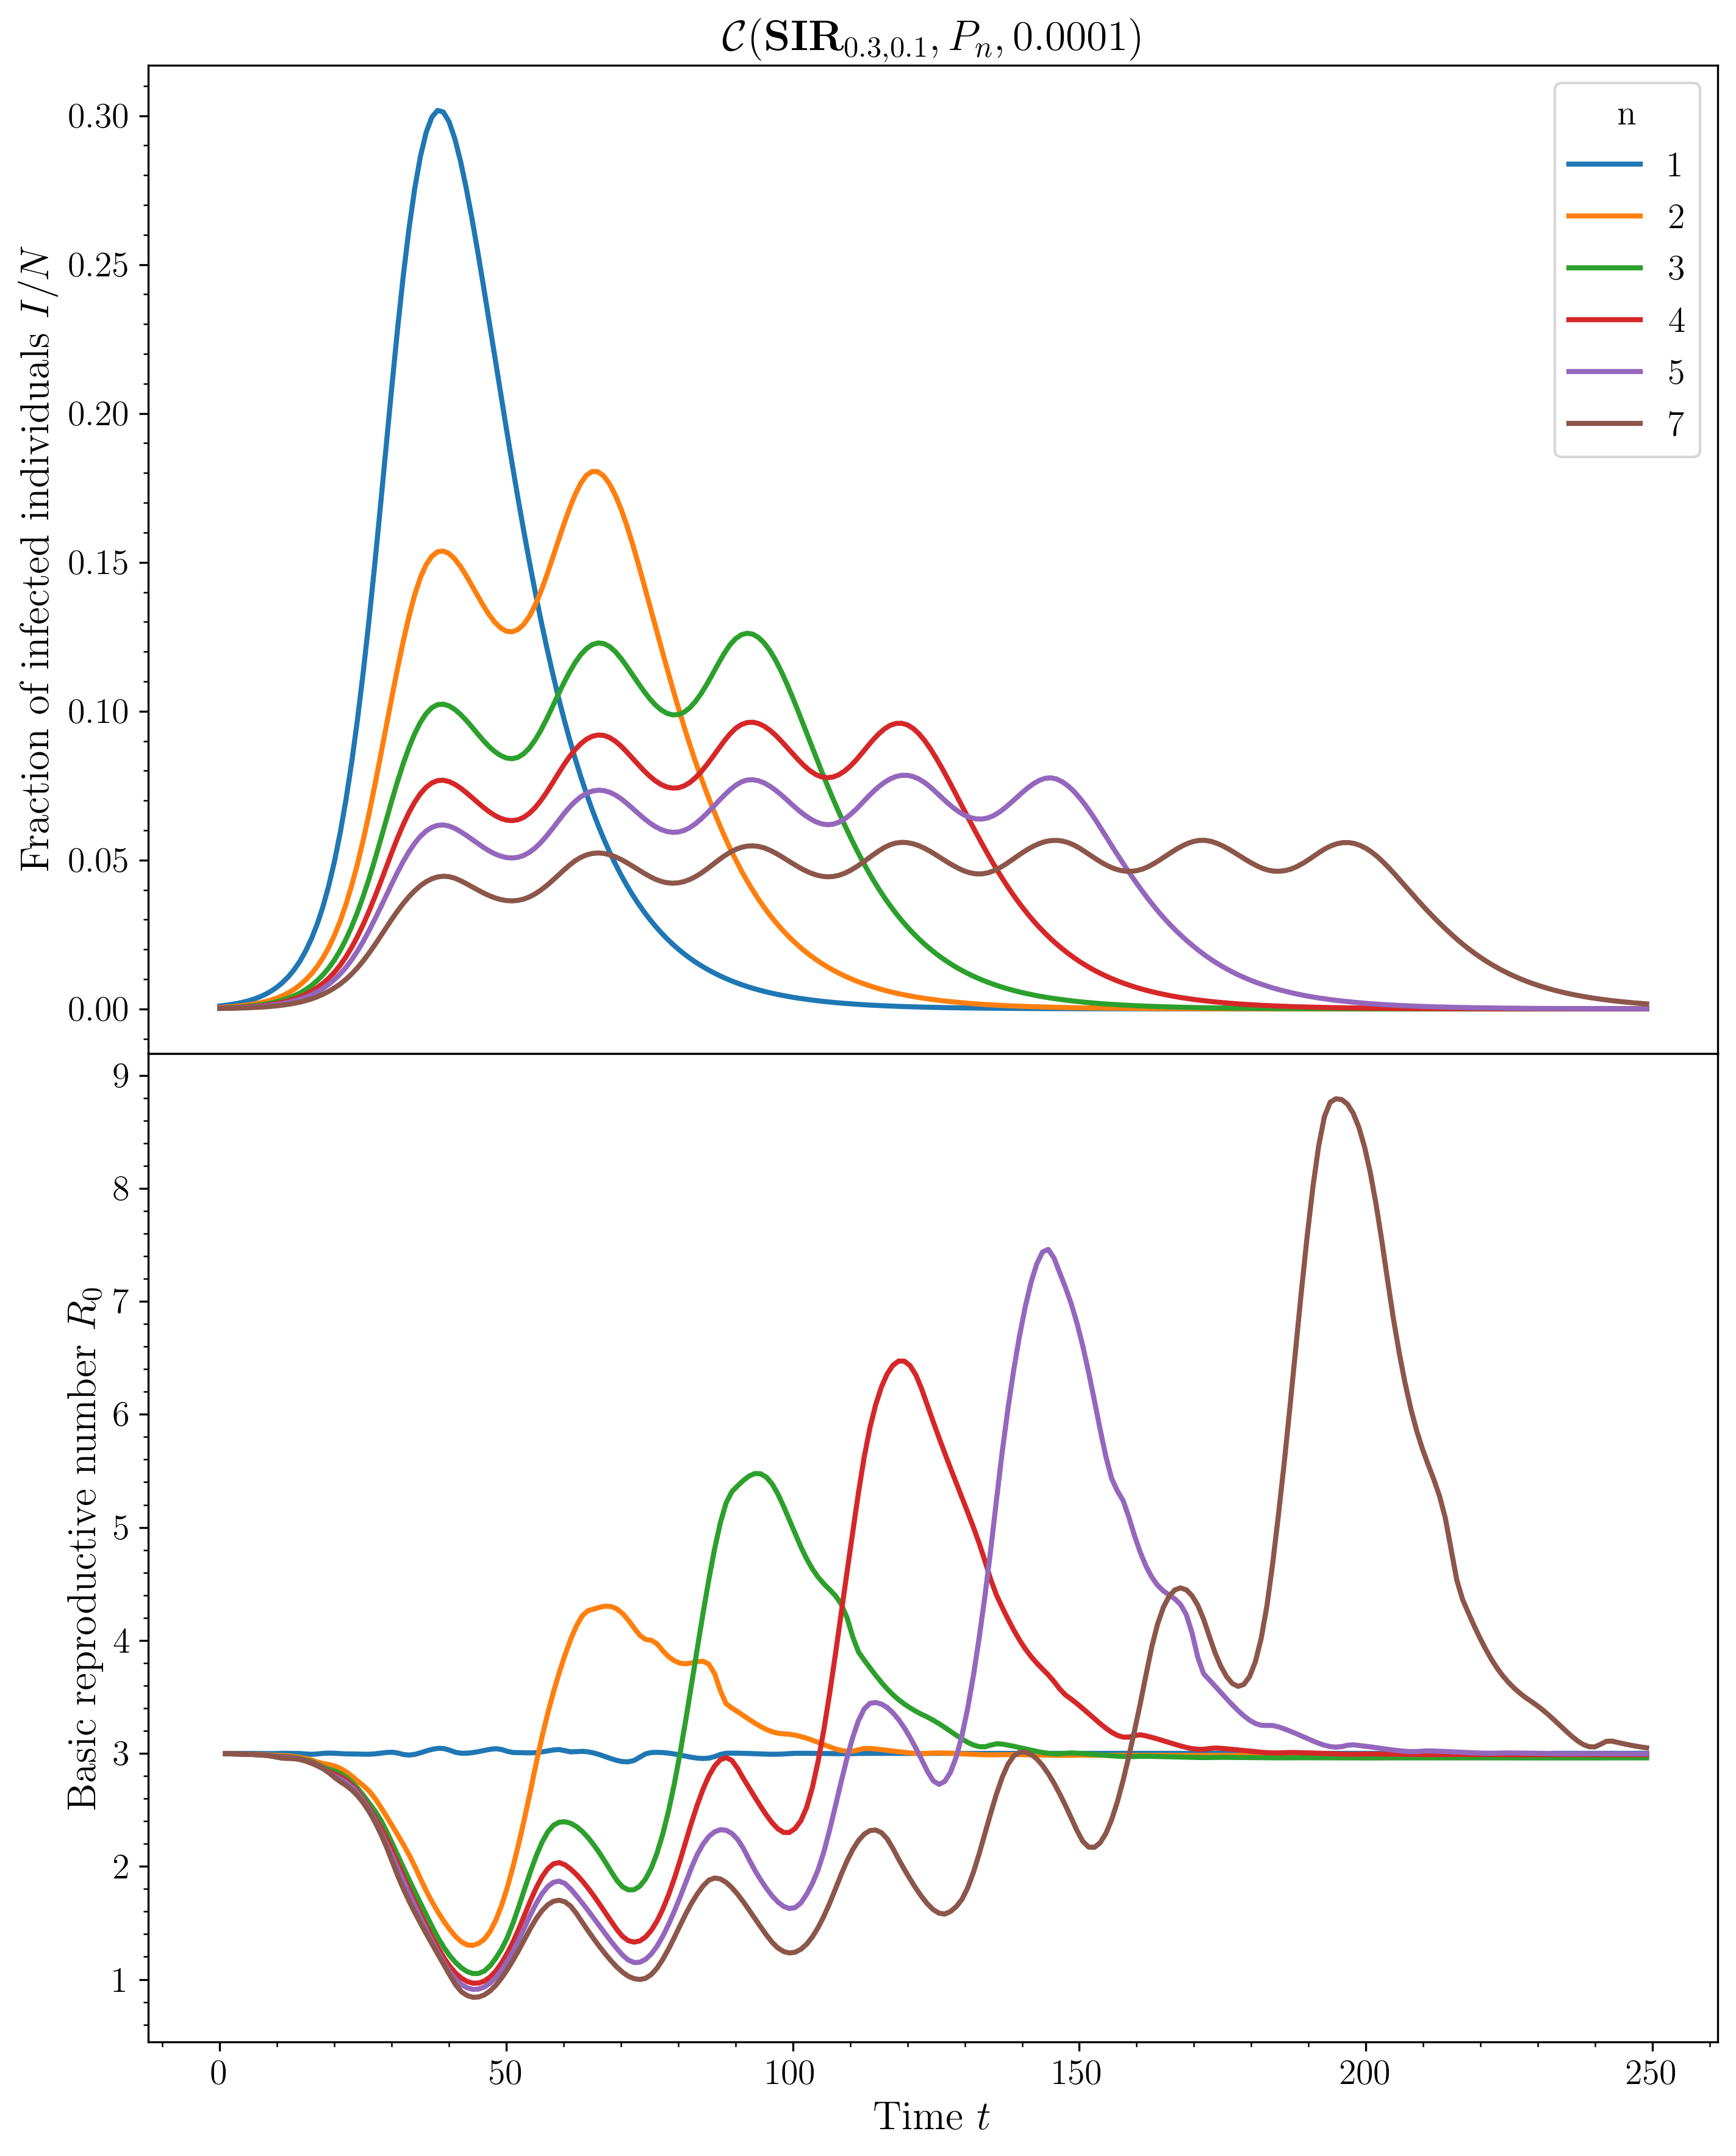

In [23]:
with plt.style.context(["paper", "size2ver"]):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    for par in [1, 2, 3, 4, 5, 7]:
        results = approx_r0(par)
        ax1.plot(results["I"] / par, label=par)
        ax2.plot(results["R0"], label=par)

    ax1.legend(title="n")
    ax2.set_xlabel("Time $t$")
    ax1.set_ylabel("Fraction of infected individuals $I/N$")
    ax2.set_ylabel("Basic reproductive number $R_0$")

    ax1.set_title(
        fr"$\mathcal{{C}}(\mathrm{{\textbf{{SIR}}}}_{{{beta}, {gamma}}}, {topology_letter[topology]}_n, {m})$"
    )
    plt.tight_layout()
    fig.subplots_adjust(hspace=0)
    plt.savefig("out/SIR-linear-communities.pdf")
    plt.show()

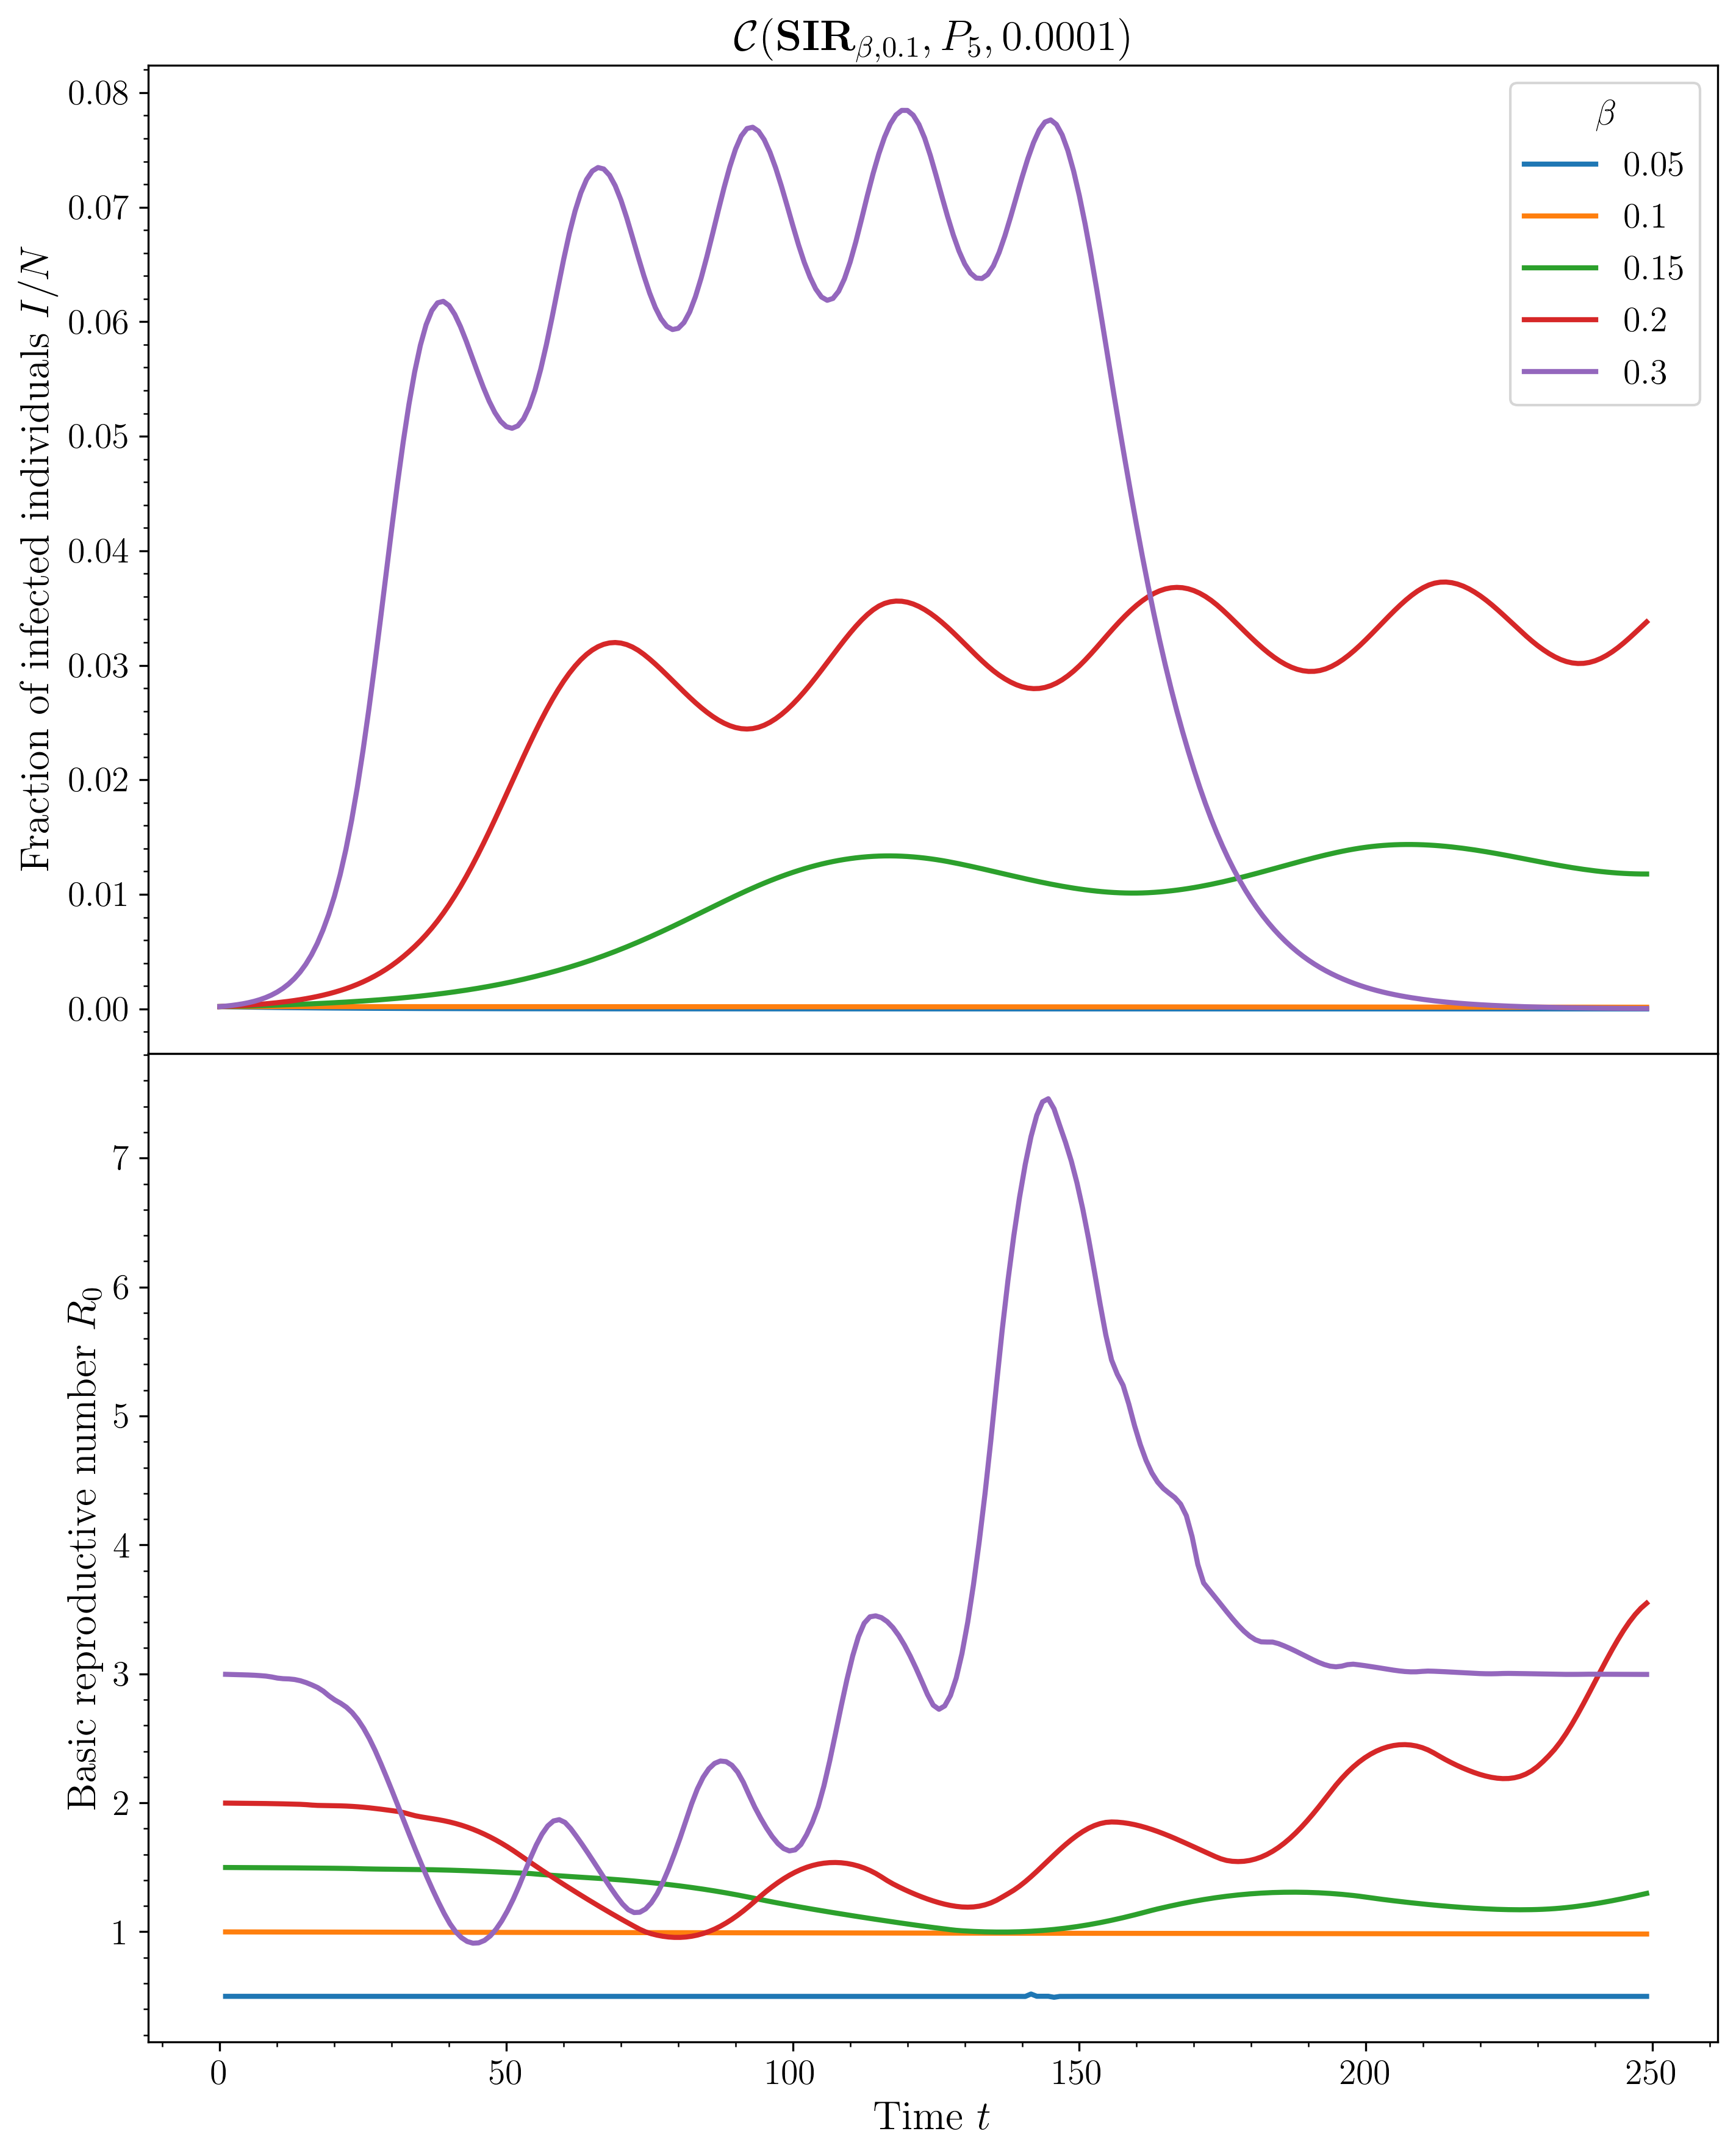

In [24]:
with plt.style.context(["paper", "size2ver"]):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    for par in [0.05, 0.1, 0.15, 0.2, 0.3]:
        results = approx_r0(n, beta=par)
        ax1.plot(results["I"] / n, label=par)
        ax2.plot(results["R0"], label=par)

    ax1.legend(title="$\\beta$")
    ax2.set_xlabel("Time $t$")
    ax1.set_ylabel("Fraction of infected individuals $I/N$")
    ax2.set_ylabel("Basic reproductive number $R_0$")

    ax1.set_title(
        fr"$\mathcal{{C}}(\mathrm{{\textbf{{SIR}}}}_{{\beta, {gamma}}}, {topology_letter[topology]}_{n}, {m})$"
    )
    plt.tight_layout()
    fig.subplots_adjust(hspace=0)
    plt.savefig("out/SIR-linear-beta.pdf")
    plt.show()

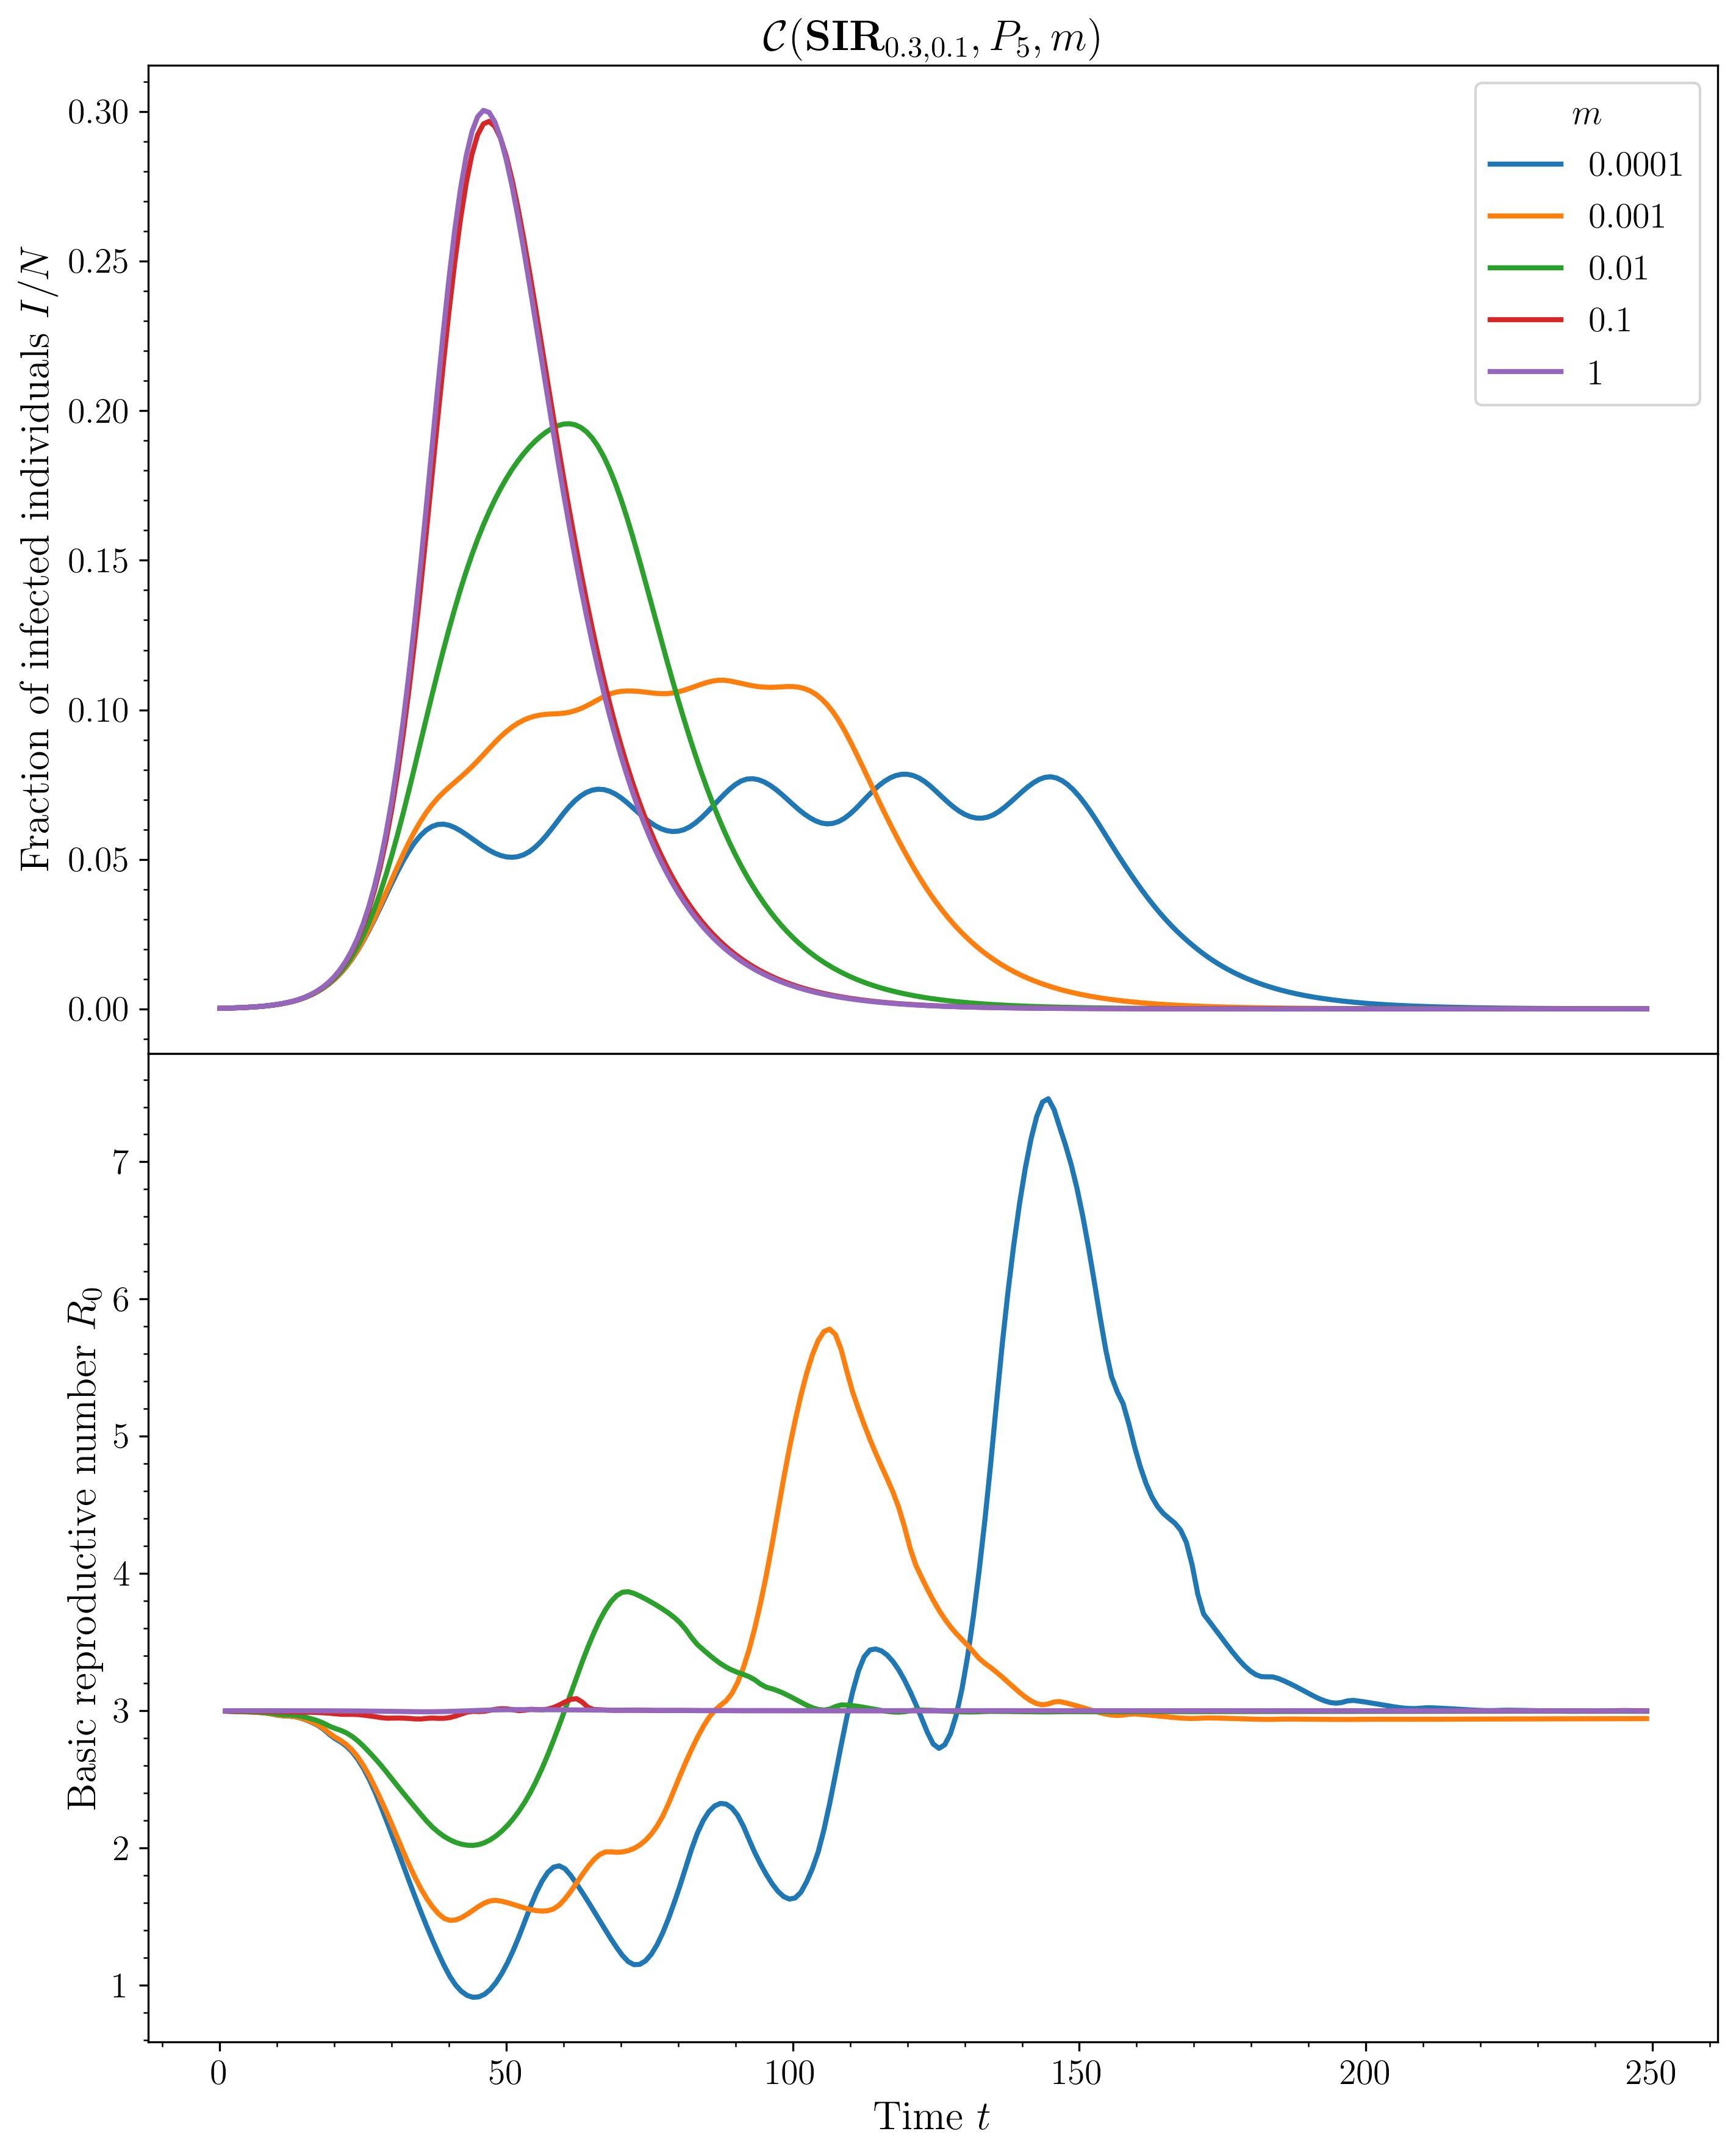

In [25]:
with plt.style.context(["paper", "size2ver"]):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    for par in [0.0001, 0.001, 0.01, 0.1, 1]:
        results = approx_r0(n, m=par)
        ax1.plot(results["I"] / n, label=par)
        ax2.plot(results["R0"], label=par)

    ax1.legend(title="$m$")
    ax2.set_xlabel("Time $t$")
    ax1.set_ylabel("Fraction of infected individuals $I/N$")
    ax2.set_ylabel("Basic reproductive number $R_0$")

    ax1.set_title(
        fr"$\mathcal{{C}}(\mathrm{{\textbf{{SIR}}}}_{{{beta}, {gamma}}}, {topology_letter[topology]}_{n}, m)$"
    )
    plt.tight_layout()
    fig.subplots_adjust(hspace=0)
    plt.savefig("out/SIR-linear-m.pdf")
    plt.show()

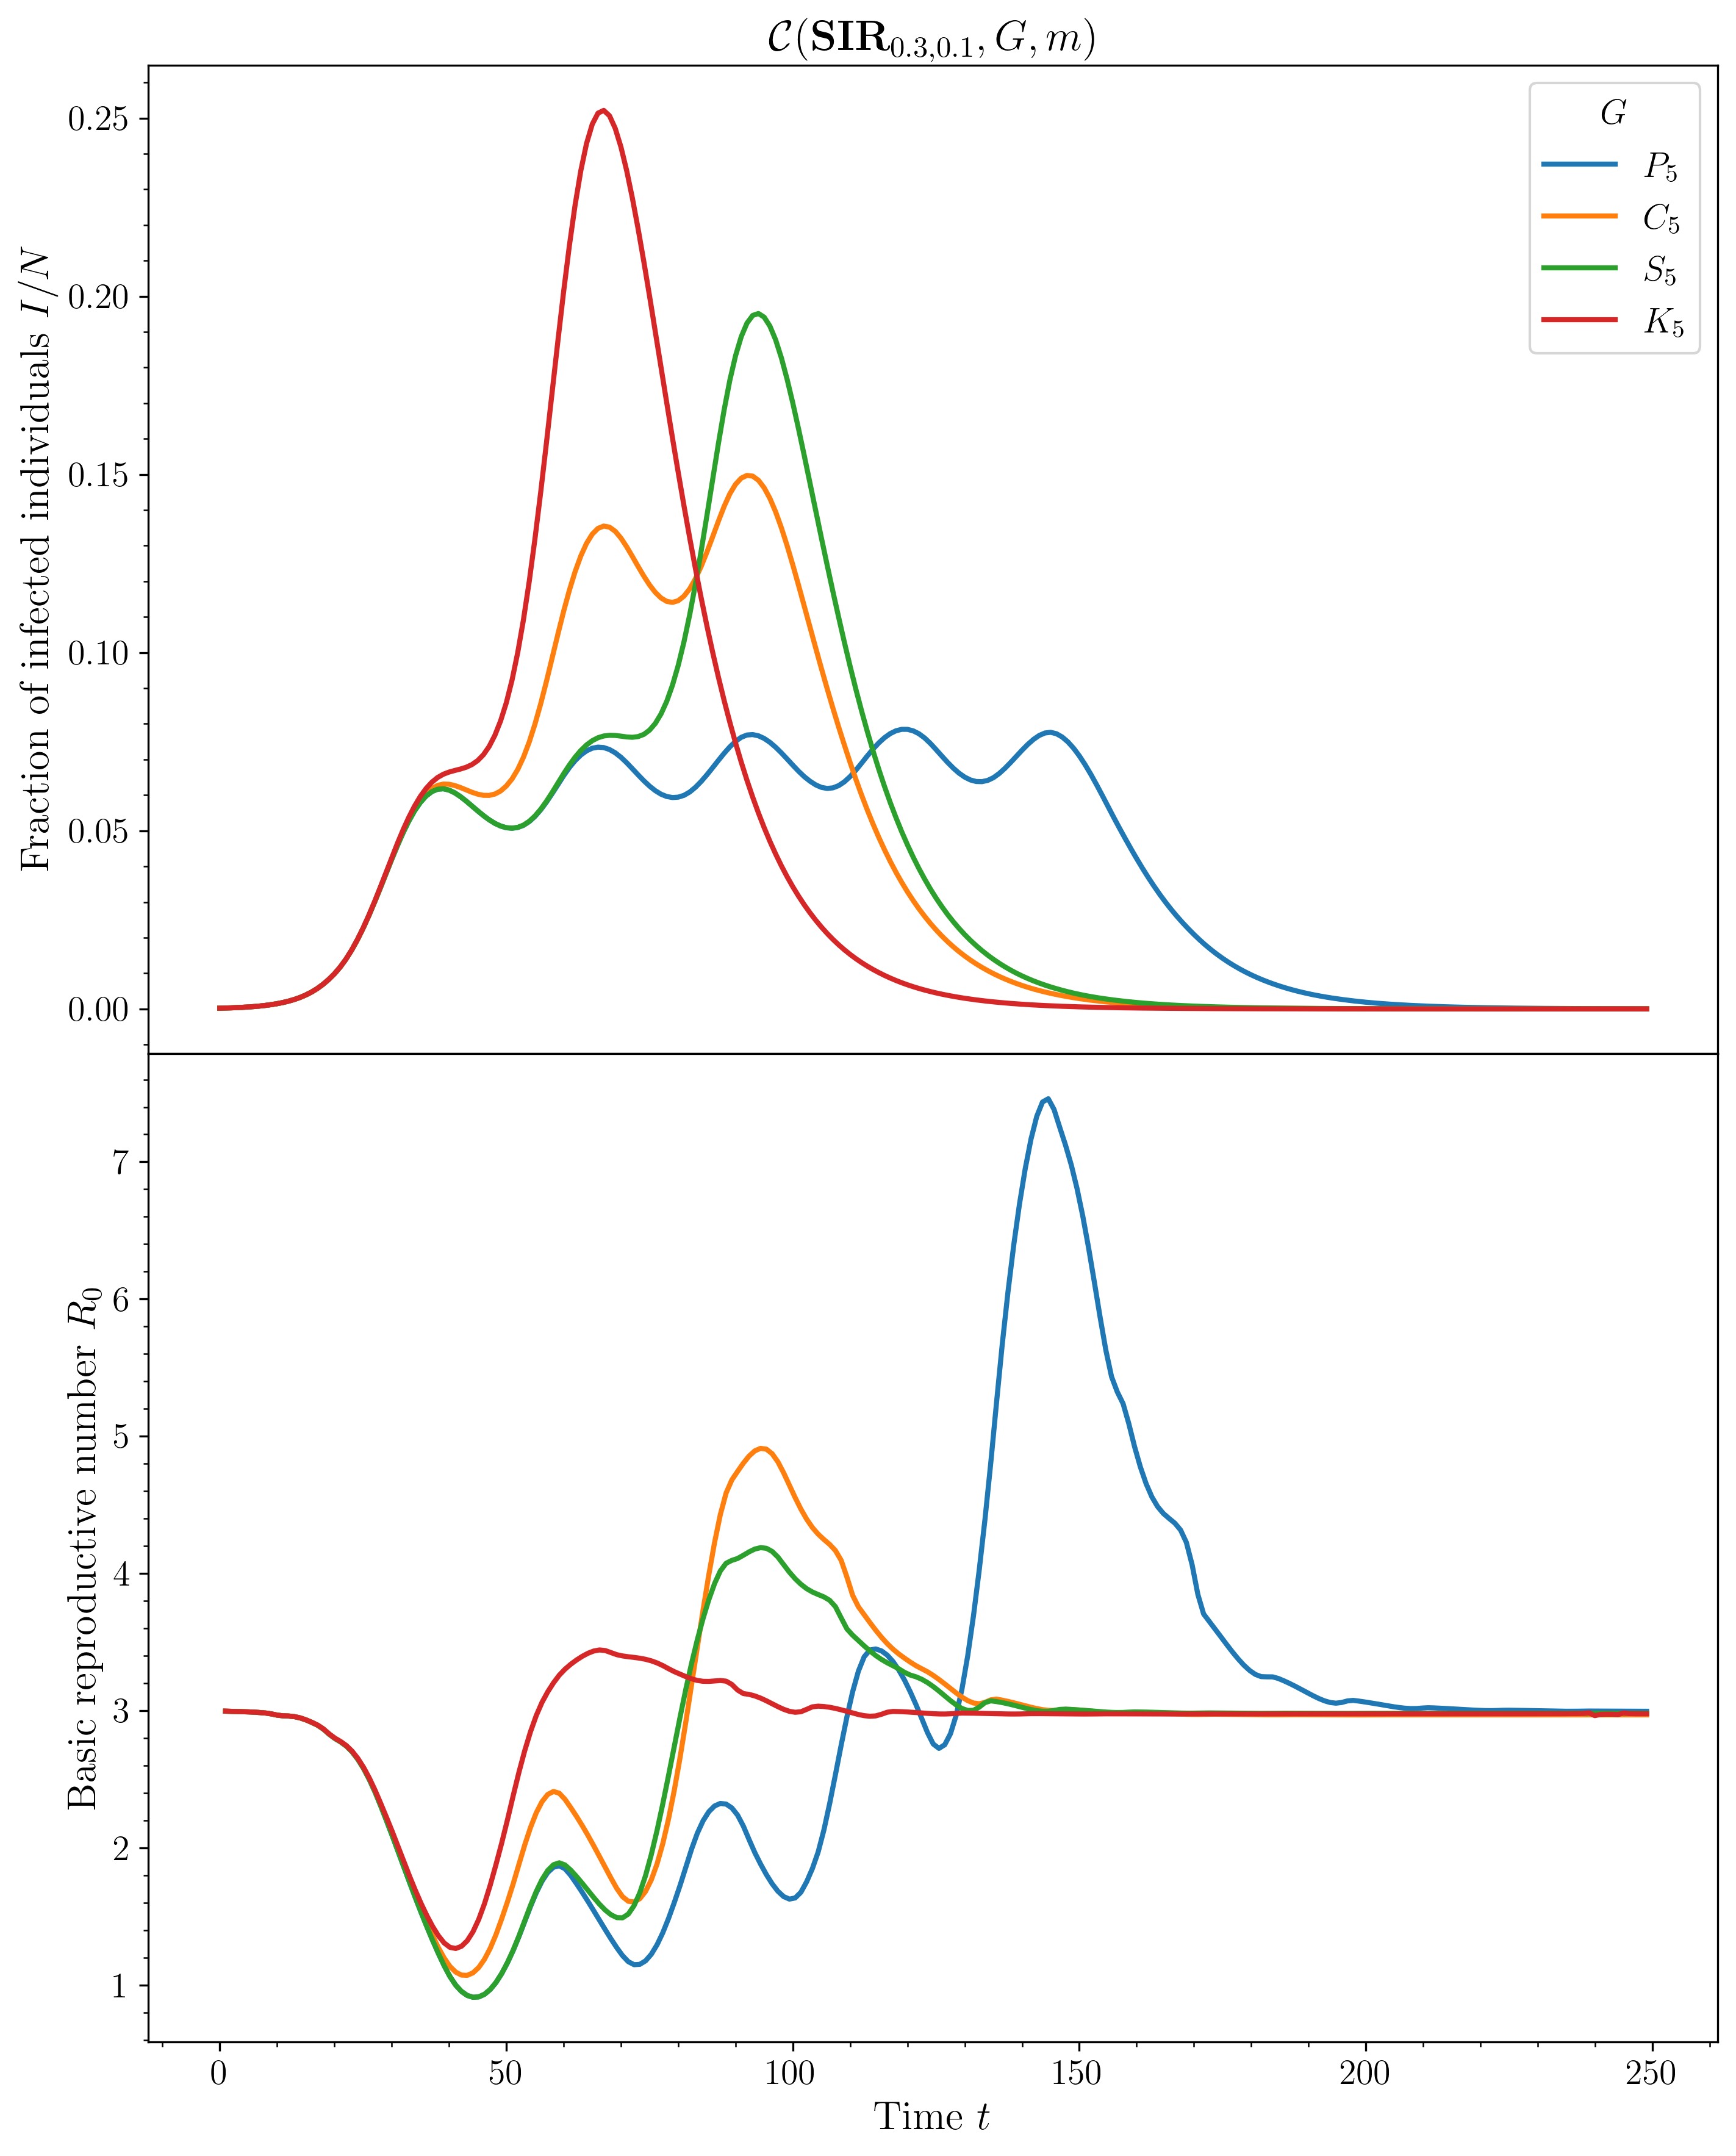

In [26]:
with plt.style.context(["paper", "size2ver"]):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    for par in ["linear", "cycle", "star2", "full"]:
        results = approx_r0(n, topology=par)
        ax1.plot(results["I"] / n, label=f"${topology_letter[par]}_{n}$")
        ax2.plot(results["R0"], label=par)

    ax1.legend(title="$G$")
    ax2.set_xlabel("Time $t$")
    ax1.set_ylabel("Fraction of infected individuals $I/N$")
    ax2.set_ylabel("Basic reproductive number $R_0$")

    ax1.set_title(
        fr"$\mathcal{{C}}(\mathrm{{\textbf{{SIR}}}}_{{{beta}, {gamma}}}, G, m)$"
    )
    plt.tight_layout()
    fig.subplots_adjust(hspace=0)
    plt.savefig("out/SIR-linear-topology.pdf")
    plt.show()